Задача изучить разные способы получения графов.

# Загрузка необходимых библиотек

In [2]:
from dotenv import load_dotenv # для загрузки ключа из файла .env
import os as os
from pymatgen.ext.matproj import MPRester
from tqdm import tqdm

In [3]:
import pandas as pd

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm, os
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error
from tqdm import tqdm

In [5]:
# MP API
from mp_api.client import MPRester

# Pymatgen
from pymatgen.io.vasp import Poscar

# Torch
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

from torch.nn import Linear


# Torch geometric
from torch_geometric.data import Data, Dataset
from torch_geometric.utils import to_networkx
from torch_geometric.transforms import KNNGraph

from torch_geometric.loader import DataLoader as DataLoader_Graph

from torch_geometric.nn import PointTransformerConv, global_mean_pool

# Utils
import networkx as nx

In [6]:
# Сброс настроек
plt.rcParams.update(plt.rcParamsDefault)

import openpyxl #, работа с excel

In [7]:
import json
import numpy as np

# Ключ Materials Project API

In [15]:
# импортируем ключ API
load_dotenv()
mp_api_key = os.environ.get('MP_API_KEY')

Задача - загрузить датасет из базы данных Materials Project, обработать данные и преобразовать их в графы для дальнейшего обучения нейросети

Разбираем вариант Кирилла Сиднова из МИСиС

# Загрузка данных

In [9]:
# class DatasetBuilder:
    
#     '''Класс для создания датасета из базы данных MaterialsProject'''

#     def __init__(self, criteria:dict=None, apikey:str=None):
#         self.criteria = criteria
#         self.apikey = apikey

#         self.rester = MPRester(apikey)

#     def query(self):
#         self.docs = self.rester.summary._search(**self.criteria)

#     @staticmethod
#     def collect(doc=None):
#       d = {}
#       for i in doc:
#         if len(i) == 2:
#           if None not in i:
#             if i[0] != 'fields_not_requested':
#               d[i[0]] = i[1]
#       return d

#     def make_dataframe(self, doc=None):
#         df = pd.DataFrame()
#         for doc in self.docs:
#           df = pd.concat([
#               df,
#               pd.DataFrame( [self.collect(doc)] )
#           ])
#         df = df.dropna() ; print('Final DataFame shape:', df.shape)
#         df = df.reset_index(drop=True)
#         self.dataframe = df

#     def get_data(self):
#         self.query()
#         self.make_dataframe()
#         return self.dataframe

In [10]:
class DatasetBuilder:
    """
    Класс для создания датасета из базы данных Materials Project (MP).
    Обеспечивает:
    1. Подключение к API MP
    2. Выполнение запросов по заданным критериям
    3. Преобразование сырых данных в структурированный DataFrame
    4. Очистку данных от пропущенных значений

    Параметры:
    ----------
    criteria : dict, optional
        Словарь критериев поиска для MP API. Пример:
        {'elements': ['Li', 'Fe', 'O'], 'nelements': {'$lte': 3}}
    apikey : str, optional
        Ключ API для доступа к Materials Project. Если None, попытается
        использовать переменную окружения MAPI_KEY.
    """

    def __init__(self, criteria: dict = None, apikey: str = None):
        """Инициализация подключения к Materials Project API"""
        self.criteria = criteria or {}  # Критерии поиска (по умолчанию пустой словарь)
        self.apikey = apikey  # API ключ (может быть None)

        # Инициализация REST-клиента для работы с Materials Project API
        # Примечание: MPRester автоматически проверяет переменные окружения,
        # если apikey не указан явно
        self.rester = MPRester(apikey)  

    def query(self):
        """
        Выполняет запрос к Materials Project API с заданными критериями.
        Результаты сохраняются в self.docs как список документов (сырые данные).
        """
        # Используем защищенный метод _search для гибкого поиска
        # Возвращает генератор документов, который мы преобразуем в список
        self.docs = list(self.rester.summary._search(**self.criteria))  
        print(f"Найдено {len(self.docs)} материалов")

    @staticmethod
    def collect(doc=None):
        """
        Статический метод для преобразования документа MP в плоский словарь.
        
        Параметры:
        ----------
        doc : dict
            Сырой документ из Materials Project API
            
        Возвращает:
        ----------
        dict
            Очищенный словарь с данными материала
        """
        d = {}
        for i in doc:
            # Фильтрация данных:
            if len(i) == 2:
                if None not in i:  # 1. Пропускаем пары с None-значениями
                    if i[0] != 'fields_not_requested':  # 2. Исключаем служебное поле 'fields_not_requested'
                        d[i[0]] = i[1]
        return d

    def make_dataframe(self):
        """
        Преобразует сырые данные из self.docs в pandas DataFrame.
        Автоматически удаляет строки с пропущенными значениями.
        """
        df = pd.DataFrame()  # Создаем пустой DataFrame
        
        # Построчная обработка каждого документа
        for doc in self.docs:
            # Для каждого документа:
            # 1. Преобразуем в плоский словарь через collect()
            # 2. Создаем временный DataFrame из одной строки
            # 3. Объединяем с основным DataFrame
            df = pd.concat([
                df,
                pd.DataFrame([self.collect(doc)])  # [] для создания DataFrame из одной строки
            ], ignore_index=True)
        
        # Очистка данных:
        # 1. Удаление строк с пропущенными значениями
        # 2. Сброс индекса после удаления строк
        df = df.dropna()
        print('Финальный размер DataFrame:', df.shape)
        df = df.reset_index(drop=True)  # Сброс индекса без создания новой колонки
        self.dataframe = df  # Сохранение результата в атрибут класса

    def get_data(self):
        """
        Основной метод для получения данных. Выполняет:
        1. Запрос к API (query)
        2. Преобразование в DataFrame (make_dataframe)
        3. Возврат готовых данных
        
        Возвращает:
        ----------
        pd.DataFrame
            Очищенный DataFrame с данными материалов
        """
        self.query()  # Получаем сырые данные
        self.make_dataframe()  # Преобразуем в DataFrame
        return self.dataframe

In [11]:
# # зафиксируем критерии запроса
# requested_fields = [
#     "composition", "structure", "formation_energy_per_atom"
# ]

# criteria = {
#     'nelements_max':2,
#     'nelements_min':2,
#     'spacegroup_symbol':'Fm-3m',
#     'fields':requested_fields,
# }

# # инициируем экземпляр класса с фиксированными критериями запроса
# db = DatasetBuilder(criteria=criteria, apikey=mp_api_key)

# df = db.get_data()

In [12]:
crystal_system="Cubic" # Фильтр по кубической кристаллической системе
nelements_max = 3 # Число элементов в составе: от 1 до 3
elements=["Si"]
num_chunks=1,  # Устанавливаем ограничение на количество загружаемых строк
chunk_size=1000

In [13]:
# зафиксируем критерии запроса
requested_fields = [
    "composition", "structure", "formation_energy_per_atom", "material_id", "formula_pretty", 
            'symmetry'
]

criteria = {
    'nelements_max':3,
    'crystal_system': 'Cubic',
    'elements':['Si'],
    'fields':requested_fields,
    'num_chunks': 1,
    'chunk_size': 1000
}

In [16]:
# инициируем экземпляр класса с фиксированными критериями запроса
db_si_cubic_1000 = DatasetBuilder(criteria=criteria, apikey=mp_api_key)

In [18]:
db_si_cubic_1000

In [19]:
df_si_cubic_1000 = db_si_cubic_1000.get_data()

C:\Users\lazarevnv\AppData\Local\Temp\ipykernel_26780\1611926248.py:37: DeprecationWarning: Accessing summary data through MPRester.summary is deprecated. Please use MPRester.materials.summary instead.
  self.docs = list(self.rester.summary._search(**self.criteria))


Retrieving SummaryDoc documents:   0%|          | 0/562 [00:00<?, ?it/s]

Найдено 562 материалов
Финальный размер DataFrame: (562, 6)


In [20]:
type(df_si_cubic_1000)

pandas.core.frame.DataFrame

In [21]:
df_si_cubic_1000[:20]

,composition,formula_pretty,symmetry,material_id,structure,formation_energy_per_atom
0,(Si),Si,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1201492,"[[ 4.63230975 14.92644472 7.37816377] Si, [13...",0.121153
1,(Si),Si,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-168,"[[0.67592785 0.67592785 0.67592785] Si, [ 0.67...",0.160021
2,(Si),Si,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1200830,"[[-6.49829314 -3.27779246 1.62942932] Si, [-3...",0.143261
3,(Si),Si,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-971661,"[[-4.17430519 -4.17430519 -1.44023201] Si, [-0...",0.107477
4,(Si),Si,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-971662,"[[0. 8.98812896 3.13519963] Si, [0. ...",0.091850
5,(Si),Si,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-27,[[0. 0. 0.] Si],0.531566
6,(Si),Si,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-149,"[[3.8891685 2.7500585 6.7362365] Si, [0.555595...",0.000000
7,(Si),Si,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-16220,"[[7.33856771 7.33856771 7.33856771] Si, [11.00...",0.393193
8,(Si),Si,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1014212,[[0. 0. 0.] Si],0.525496
9,(Si),Si,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1072544,"[[-3.33608319 0. -1.6680416 ] Si, [-3...",0.222399


In [35]:
df_si_cubic_1000[10:20]

,composition,formula_pretty,symmetry,material_id,structure,formation_energy_per_atom
10,"(Si, O)",SiO2,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-560836,"[[3.66050333 7.35399043 3.12668689] Si, [1.439...",-3.044315
11,"(Si, Tc)",SiTc,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1079910,"[[3.1091025 0.73605216 1.63699818] Si, [0.736...",-0.520418
12,"(Si, Ni)",SiNi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1095177,"[[2.94167781 0.68983081 1.56201619] Si, [0.689...",-0.374057
13,"(Mn, Si)",MnSi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1431,"[[3.87240559 2.85390008 1.6301892 ] Mn, [2.854...",-0.360732
14,"(Si, Rh)",SiRh,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1483,"[[0.74086379 1.60217555 3.08390314] Si, [1.602...",-0.800081
15,"(Si, Ru)",SiRu,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-189,"[[0.76478075 1.58951694 3.11907844] Si, [1.589...",-0.654533
16,"(Si, Os)",SiOs,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-2488,"[[0.78525696 1.59773892 3.16825284] Si, [1.597...",-0.392482
17,"(Cr, Si)",CrSi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-7576,"[[3.96529276 2.93399624 1.66552976] Cr, [2.933...",-0.142375
18,"(Co, Si)",CoSi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-7577,"[[3.74360675 2.8310704 1.5520477 ] Co, [2.831...",-0.492925
19,"(Re, Si)",ReSi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-7948,"[[4.13288122 3.02807868 1.74589459] Re, [3.028...",-0.264138


In [23]:
df_si_cubic_1000.tail(3)

,composition,formula_pretty,symmetry,material_id,structure,formation_energy_per_atom
559,"(Mg, Si, Bi)",Mg63Si32Bi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1194890,"[[9.4954585 0. 0. ] Mg, [0. ...",-0.066535
560,"(Mg, Si, Bi)",Mg64Si32Bi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1194936,"[[4.78909723 4.78909723 7.96644927] Mg, [4.789...",-0.049193
561,"(Na, Si)",NaSi34,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1220929,"[[11.040783 11.040783 11.040783] Na, [0. 0. 0....",0.113020


In [27]:
# df_si_cubic_1000

### Пример преобразования данных в граф

In [38]:
df_si_cubic_1000[10:11]

,composition,formula_pretty,symmetry,material_id,structure,formation_energy_per_atom
10,"(Si, O)",SiO2,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-560836,"[[3.66050333 7.35399043 3.12668689] Si, [1.439...",-3.044315


In [48]:
# определим id нашего примера
sample_idx = df_si_cubic_1000[10:11].index[0]
sample_idx

10

In [52]:
# получим струкруру из нашего примера
sample_struct = df_si_cubic_1000.loc[sample_idx, 'structure']
sample_struct

Structure Summary
Lattice
    abc : 8.793326 8.793326 8.793326
 angles : 90.0 90.0 90.0
 volume : 679.9226719388113
      A : 8.793326 0.0 0.0
      B : 0.0 8.793326 0.0
      C : 0.0 0.0 8.793326
    pbc : True True True
PeriodicSite: Si (3.661, 7.354, 3.127) [0.4163, 0.8363, 0.3556]
PeriodicSite: Si (1.439, 5.667, 3.661) [0.1637, 0.6444, 0.4163]
PeriodicSite: Si (3.127, 5.133, 1.439) [0.3556, 0.5837, 0.1637]
PeriodicSite: Si (7.354, 3.127, 3.661) [0.8363, 0.3556, 0.4163]
PeriodicSite: Si (7.354, 5.667, 5.133) [0.8363, 0.6444, 0.5837]
PeriodicSite: Si (5.133, 1.439, 3.127) [0.5837, 0.1637, 0.3556]
PeriodicSite: Si (3.127, 3.661, 7.354) [0.3556, 0.4163, 0.8363]
PeriodicSite: Si (5.133, 7.354, 5.667) [0.5837, 0.8363, 0.6444]
PeriodicSite: Si (5.667, 3.661, 1.439) [0.6444, 0.4163, 0.1637]
PeriodicSite: Si (1.439, 3.127, 5.133) [0.1637, 0.3556, 0.5837]
PeriodicSite: Si (5.667, 5.133, 7.354) [0.6444, 0.5837, 0.8363]
PeriodicSite: Si (3.661, 1.439, 5.667) [0.4163, 0.1637, 0.6444]
PeriodicSi

In [53]:
# смотрим элемент структуры sites - местоположения
sample_struct.sites

[PeriodicSite: Si (3.661, 7.354, 3.127) [0.4163, 0.8363, 0.3556],
 PeriodicSite: Si (1.439, 5.667, 3.661) [0.1637, 0.6444, 0.4163],
 PeriodicSite: Si (3.127, 5.133, 1.439) [0.3556, 0.5837, 0.1637],
 PeriodicSite: Si (7.354, 3.127, 3.661) [0.8363, 0.3556, 0.4163],
 PeriodicSite: Si (7.354, 5.667, 5.133) [0.8363, 0.6444, 0.5837],
 PeriodicSite: Si (5.133, 1.439, 3.127) [0.5837, 0.1637, 0.3556],
 PeriodicSite: Si (3.127, 3.661, 7.354) [0.3556, 0.4163, 0.8363],
 PeriodicSite: Si (5.133, 7.354, 5.667) [0.5837, 0.8363, 0.6444],
 PeriodicSite: Si (5.667, 3.661, 1.439) [0.6444, 0.4163, 0.1637],
 PeriodicSite: Si (1.439, 3.127, 5.133) [0.1637, 0.3556, 0.5837],
 PeriodicSite: Si (5.667, 5.133, 7.354) [0.6444, 0.5837, 0.8363],
 PeriodicSite: Si (3.661, 1.439, 5.667) [0.4163, 0.1637, 0.6444],
 PeriodicSite: O (4.397, 0.0, 2.946) [0.5, 0.0, 0.335],
 PeriodicSite: O (4.397, 0.0, 5.847) [0.5, 0.0, 0.665],
 PeriodicSite: O (7.182, 3.655, 2.094) [0.8168, 0.4157, 0.2382],
 PeriodicSite: O (2.184, 4.397,

In [55]:
type(sample_struct)

pymatgen.core.structure.Structure

In [54]:
# Создаем суперячейку 2x2x2 для корректного учета периодических границ
supercell = sample_struct.copy()

In [56]:
supercell

Structure Summary
Lattice
    abc : 8.793326 8.793326 8.793326
 angles : 90.0 90.0 90.0
 volume : 679.9226719388113
      A : 8.793326 0.0 0.0
      B : 0.0 8.793326 0.0
      C : 0.0 0.0 8.793326
    pbc : True True True
PeriodicSite: Si (3.661, 7.354, 3.127) [0.4163, 0.8363, 0.3556]
PeriodicSite: Si (1.439, 5.667, 3.661) [0.1637, 0.6444, 0.4163]
PeriodicSite: Si (3.127, 5.133, 1.439) [0.3556, 0.5837, 0.1637]
PeriodicSite: Si (7.354, 3.127, 3.661) [0.8363, 0.3556, 0.4163]
PeriodicSite: Si (7.354, 5.667, 5.133) [0.8363, 0.6444, 0.5837]
PeriodicSite: Si (5.133, 1.439, 3.127) [0.5837, 0.1637, 0.3556]
PeriodicSite: Si (3.127, 3.661, 7.354) [0.3556, 0.4163, 0.8363]
PeriodicSite: Si (5.133, 7.354, 5.667) [0.5837, 0.8363, 0.6444]
PeriodicSite: Si (5.667, 3.661, 1.439) [0.6444, 0.4163, 0.1637]
PeriodicSite: Si (1.439, 3.127, 5.133) [0.1637, 0.3556, 0.5837]
PeriodicSite: Si (5.667, 5.133, 7.354) [0.6444, 0.5837, 0.8363]
PeriodicSite: Si (3.661, 1.439, 5.667) [0.4163, 0.1637, 0.6444]
PeriodicSi

In [ ]:
# смотрим количество атомов в ячейке
len(supercell)

36

In [ ]:
# Создаем суперячейку 2x2x2 для корректного учета периодических границ
supercell.make_supercell([2, 2, 2])  # Теперь минимум 8 атомов (если в ячейке был 1 атом)

Structure Summary
Lattice
    abc : 17.586652 17.586652 17.586652
 angles : 90.0 90.0 90.0
 volume : 5439.38137551049
      A : 17.586652 0.0 0.0
      B : 0.0 17.586652 0.0
      C : 0.0 0.0 17.586652
    pbc : True True True
PeriodicSite: Si (3.661, 7.354, 3.127) [0.2081, 0.4182, 0.1778]
PeriodicSite: Si (3.661, 7.354, 11.92) [0.2081, 0.4182, 0.6778]
PeriodicSite: Si (3.661, 16.15, 3.127) [0.2081, 0.9182, 0.1778]
PeriodicSite: Si (3.661, 16.15, 11.92) [0.2081, 0.9182, 0.6778]
PeriodicSite: Si (12.45, 7.354, 3.127) [0.7081, 0.4182, 0.1778]
PeriodicSite: Si (12.45, 7.354, 11.92) [0.7081, 0.4182, 0.6778]
PeriodicSite: Si (12.45, 16.15, 3.127) [0.7081, 0.9182, 0.1778]
PeriodicSite: Si (12.45, 16.15, 11.92) [0.7081, 0.9182, 0.6778]
PeriodicSite: Si (1.439, 5.667, 3.661) [0.08184, 0.3222, 0.2081]
PeriodicSite: Si (1.439, 5.667, 12.45) [0.08184, 0.3222, 0.7081]
PeriodicSite: Si (1.439, 14.46, 3.661) [0.08184, 0.8222, 0.2081]
PeriodicSite: Si (1.439, 14.46, 12.45) [0.08184, 0.8222, 0.7081]
P

In [59]:
# смотрим количество атомов в ячейке после получения суперячейки
len(supercell)

288

In [60]:
supercell.lattice

Lattice
    abc : 17.586652 17.586652 17.586652
 angles : 90.0 90.0 90.0
 volume : 5439.38137551049
      A : 17.586652 0.0 0.0
      B : 0.0 17.586652 0.0
      C : 0.0 0.0 17.586652
    pbc : True True True

In [ ]:
# смотрим свойства элемента
supercell.species[0]

Element Si

In [ ]:
# смотрим свойства элемента
supercell.sites[0].species.elements[0]

Element Si

In [ ]:
# смотрим свойства элемента
supercell.sites[0].species.elements[0].Z

14

In [ ]:
# смотрим свойства элемента
supercell.sites[0].species.elements[0].molar_volume

12.06

In [ ]:
# смотрим свойства элемента
supercell.sites[0].species.elements[0].electron_affinity

1.38952128

#### Преобразуем atoms - атомные свойства и pos - координаты

In [82]:
# Инициализация пустых списков для хранения атомных свойств и координат
atoms, pos = [], []

In [83]:
# добавим атомные свойства и координаты в отдельные переменные типа [list]
for site in sample_struct.sites:
    atoms.append([
        site.species.elements[0].Z, # Атомный номер (количество протонов)
        site.species.elements[0].molar_volume, # Молярный объем
        site.species.elements[0].electron_affinity,  # Сродство к электрону
        site.species.elements[0].min_oxidation_state, # Минимальная степень окисления
        site.species.elements[0].max_oxidation_state, # Максимальная степень окисления
    ])

     # Добавляем координаты атома в pos
    pos.append(site.coords)  # Декартовы координаты [x, y, z]

In [84]:
atoms

[[14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [14, 12.06, 1.38952128, -4, 4],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4611053, -2, 2],
 [8, 17.36, 1.4

In [85]:
pos

[array([3.66050333, 7.35399043, 3.12668689]),
 array([1.43933557, 5.66663911, 3.66050333]),
 array([3.12668689, 5.13282267, 1.43933557]),
 array([7.35399043, 3.12668689, 3.66050333]),
 array([7.35399043, 5.66663911, 5.13282267]),
 array([5.13282267, 1.43933557, 3.12668689]),
 array([3.12668689, 3.66050333, 7.35399043]),
 array([5.13282267, 7.35399043, 5.66663911]),
 array([5.66663911, 3.66050333, 1.43933557]),
 array([1.43933557, 3.12668689, 5.13282267]),
 array([5.66663911, 5.13282267, 7.35399043]),
 array([3.66050333, 1.43933557, 5.66663911]),
 array([4.396663  , 0.        , 2.94586973]),
 array([4.396663  , 0.        , 5.84745627]),
 array([7.1822216 , 3.65549993, 2.09423611]),
 array([2.18393683, 4.396663  , 4.396663  ]),
 array([6.69908989, 7.1822216 , 5.13782607]),
 array([5.13782607, 2.09423611, 1.6111044 ]),
 array([3.65549993, 6.69908989, 1.6111044 ]),
 array([2.09423611, 1.6111044 , 5.13782607]),
 array([0.        , 5.84745627, 4.396663  ]),
 array([6.60938917, 4.396663  , 4.

In [86]:
# torch_geometric is designed to work with torch.tensor objects 
# (torch_geometric предназначен для работы с объектами torch.tensor)

# Преобразование списков в тензоры PyTorch для совместимости с torch_geometric
atoms = torch.tensor(atoms).to(torch.float32)  # Преобразуем в тензор float32
pos = torch.tensor(pos).to(torch.float32)      # Координаты также в float32

C:\Users\lazarevnv\AppData\Local\Temp\ipykernel_26780\2466273431.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  pos = torch.tensor(pos).to(torch.float32)      # Координаты также в float32


In [ ]:
# смотрим что получилось
atoms

tensor([[14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 

In [89]:
# смотрим что получилось
pos

tensor([[3.6605, 7.3540, 3.1267],
        [1.4393, 5.6666, 3.6605],
        [3.1267, 5.1328, 1.4393],
        [7.3540, 3.1267, 3.6605],
        [7.3540, 5.6666, 5.1328],
        [5.1328, 1.4393, 3.1267],
        [3.1267, 3.6605, 7.3540],
        [5.1328, 7.3540, 5.6666],
        [5.6666, 3.6605, 1.4393],
        [1.4393, 3.1267, 5.1328],
        [5.6666, 5.1328, 7.3540],
        [3.6605, 1.4393, 5.6666],
        [4.3967, 0.0000, 2.9459],
        [4.3967, 0.0000, 5.8475],
        [7.1822, 3.6555, 2.0942],
        [2.1839, 4.3967, 4.3967],
        [6.6991, 7.1822, 5.1378],
        [5.1378, 2.0942, 1.6111],
        [3.6555, 6.6991, 1.6111],
        [2.0942, 1.6111, 5.1378],
        [0.0000, 5.8475, 4.3967],
        [6.6094, 4.3967, 4.3967],
        [4.3967, 6.6094, 4.3967],
        [0.0000, 2.9459, 4.3967],
        [7.1822, 5.1378, 6.6991],
        [3.6555, 2.0942, 7.1822],
        [4.3967, 4.3967, 2.1839],
        [1.6111, 3.6555, 6.6991],
        [1.6111, 5.1378, 2.0942],
        [5.847

#### создадим тензор lattice для параметров решетки - векторов трансляций 

In [118]:
supercell

Structure Summary
Lattice
    abc : 17.586652 17.586652 17.586652
 angles : 90.0 90.0 90.0
 volume : 5439.38137551049
      A : 17.586652 0.0 0.0
      B : 0.0 17.586652 0.0
      C : 0.0 0.0 17.586652
    pbc : True True True
PeriodicSite: Si (3.661, 7.354, 3.127) [0.2081, 0.4182, 0.1778]
PeriodicSite: Si (3.661, 7.354, 11.92) [0.2081, 0.4182, 0.6778]
PeriodicSite: Si (3.661, 16.15, 3.127) [0.2081, 0.9182, 0.1778]
PeriodicSite: Si (3.661, 16.15, 11.92) [0.2081, 0.9182, 0.6778]
PeriodicSite: Si (12.45, 7.354, 3.127) [0.7081, 0.4182, 0.1778]
PeriodicSite: Si (12.45, 7.354, 11.92) [0.7081, 0.4182, 0.6778]
PeriodicSite: Si (12.45, 16.15, 3.127) [0.7081, 0.9182, 0.1778]
PeriodicSite: Si (12.45, 16.15, 11.92) [0.7081, 0.9182, 0.6778]
PeriodicSite: Si (1.439, 5.667, 3.661) [0.08184, 0.3222, 0.2081]
PeriodicSite: Si (1.439, 5.667, 12.45) [0.08184, 0.3222, 0.7081]
PeriodicSite: Si (1.439, 14.46, 3.661) [0.08184, 0.8222, 0.2081]
PeriodicSite: Si (1.439, 14.46, 12.45) [0.08184, 0.8222, 0.7081]
P

In [ ]:
sample_struct.sites

In [121]:
sample_struct.lattice

Lattice
    abc : 8.793326 8.793326 8.793326
 angles : 90.0 90.0 90.0
 volume : 679.9226719388113
      A : 8.793326 0.0 0.0
      B : 0.0 8.793326 0.0
      C : 0.0 0.0 8.793326
    pbc : True True True

In [120]:
sample_struct.lattice.matrix

array([[8.793326, 0.      , 0.      ],
       [0.      , 8.793326, 0.      ],
       [0.      , 0.      , 8.793326]])

In [126]:
torch.tensor(sample_struct.lattice.matrix)

tensor([[8.7933, 0.0000, 0.0000],
        [0.0000, 8.7933, 0.0000],
        [0.0000, 0.0000, 8.7933]], dtype=torch.float64)

In [127]:
torch.tensor(sample_struct.lattice.matrix, dtype=torch.float32)

tensor([[8.7933, 0.0000, 0.0000],
        [0.0000, 8.7933, 0.0000],
        [0.0000, 0.0000, 8.7933]])

In [128]:
torch.tensor(sample_struct.lattice.matrix, dtype=torch.float32).flatten()

tensor([8.7933, 0.0000, 0.0000, 0.0000, 8.7933, 0.0000, 0.0000, 0.0000, 8.7933])

In [133]:
torch.tensor(sample_struct.lattice.matrix, dtype=torch.float32).flatten().unsqueeze(0)

tensor([[8.7933, 0.0000, 0.0000, 0.0000, 8.7933, 0.0000, 0.0000, 0.0000, 8.7933]])

In [134]:
# создадим тензор для параметров решетки - векторов трансляций 
lattice = torch.tensor(sample_struct.lattice.matrix, dtype=torch.float32).flatten().unsqueeze(0)

In [135]:
lattice

tensor([[8.7933, 0.0000, 0.0000, 0.0000, 8.7933, 0.0000, 0.0000, 0.0000, 8.7933]])

На следующем шаге мы создадим специальную структуру данных `torch_geometric.data.Данные` - основу для будущего графа. В эту структуру мы поместим собранную информацию об узлах графа. 

In [113]:
# создаём структуру данных, помоему это и есть граф
graph = Data(x=atoms, pos=pos)

In [136]:
# создаём структуру данных, помоему это и есть граф
graph_full = Data(x=atoms, pos=pos, lattice=lattice)

In [91]:
Data

torch_geometric.data.data.Data

In [114]:
graph

Data(x=[36, 5], pos=[36, 3])

In [137]:
graph_full

Data(x=[36, 5], pos=[36, 3], lattice=[1, 9])

In [94]:
# это тип данных из библиотеки torch_geometric.data
type(graph)

torch_geometric.data.data.Data

In [96]:
# смотрим какие есть ключи в графе
graph.keys()

['x', 'pos']

In [139]:
graph_full.keys()

['x', 'pos', 'lattice']

In [140]:
graph_full.lattice

tensor([[8.7933, 0.0000, 0.0000, 0.0000, 8.7933, 0.0000, 0.0000, 0.0000, 8.7933]])

In [115]:
# смотрим тензор с характеристиками атомов
graph.x

tensor([[14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 

In [ ]:
# смотрим тензор с декартовыми координатами атомов
graph.pos

tensor([[3.6605, 7.3540, 3.1267],
        [1.4393, 5.6666, 3.6605],
        [3.1267, 5.1328, 1.4393],
        [7.3540, 3.1267, 3.6605],
        [7.3540, 5.6666, 5.1328],
        [5.1328, 1.4393, 3.1267],
        [3.1267, 3.6605, 7.3540],
        [5.1328, 7.3540, 5.6666],
        [5.6666, 3.6605, 1.4393],
        [1.4393, 3.1267, 5.1328],
        [5.6666, 5.1328, 7.3540],
        [3.6605, 1.4393, 5.6666],
        [4.3967, 0.0000, 2.9459],
        [4.3967, 0.0000, 5.8475],
        [7.1822, 3.6555, 2.0942],
        [2.1839, 4.3967, 4.3967],
        [6.6991, 7.1822, 5.1378],
        [5.1378, 2.0942, 1.6111],
        [3.6555, 6.6991, 1.6111],
        [2.0942, 1.6111, 5.1378],
        [0.0000, 5.8475, 4.3967],
        [6.6094, 4.3967, 4.3967],
        [4.3967, 6.6094, 4.3967],
        [0.0000, 2.9459, 4.3967],
        [7.1822, 5.1378, 6.6991],
        [3.6555, 2.0942, 7.1822],
        [4.3967, 4.3967, 2.1839],
        [1.6111, 3.6555, 6.6991],
        [1.6111, 5.1378, 2.0942],
        [5.847

#### Преобразуем данные о связях edge_index - матрица смежности

Поскольку у нас уже есть информация об узлах, нам нужно определить [смежность matrix](https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0_%D1%81%D0%BC%D0%B5%D0%B6%D0%BD%D0%BE%D1%81%D1%82%D0%B8) графа. Для этого мы построим связи между узлами (атомами) на основе информации об их расположении в пространстве относительно друг друга (в декартовом пространстве). Метод "KNN Graph" вернет матрицу смежности графа при условии, что присутствует поле данных `pos`. Аргумент `k=6`, указанный при инициализации объекта `torch_geometric.transforms.KNN Graph", определяет количество **ближайших соседей**, между которыми будут построены ребра. 

In [ ]:
# инициируем метод ближайших соседей
# # Инициализация преобразователя K-ближайших соседей (KNN) с k=6
kng = KNNGraph(k=6)

In [ ]:
# добавим матрицу смежности в наш граф
connected_graph = kng(graph)
# # На выходе получаем новый граф с добавленными ребрами на основе KNN
# # Исходные признаки узлов (x) и координаты (pos) сохраняются

In [141]:
# добавим матрицу смежности в наш граф
connected_graph_full = kng(graph_full)

In [ ]:
# получили тот же граф только с матрицей смежности
connected_graph

Data(x=[36, 5], pos=[36, 3], edge_index=[2, 216])

In [142]:
connected_graph_full

Data(x=[36, 5], pos=[36, 3], lattice=[1, 9], edge_index=[2, 216])

In [ ]:
# это первый тензор из матрицы смежности - что контактирует, номера атомов которые контактируют с другими атомами из второго тензора
print('edge_src:', connected_graph.edge_index[0])

edge_src: tensor([22, 18, 35,  1,  2,  7, 20, 15, 35, 28,  0,  2, 31, 26, 28, 18,  1,  0,
        21, 30, 14,  8,  5,  4, 21, 16, 24,  7, 10,  3, 12, 34, 17, 30,  8,  3,
        32, 27, 25, 11,  9, 10, 22, 33, 16, 10,  4,  0, 29, 26, 14, 17,  3,  5,
        23, 15, 19, 27, 11,  6, 32, 24, 33,  7,  4,  6, 13, 34, 25, 19,  6,  9,
         5, 17, 34, 30, 13, 11, 11, 25, 34, 19, 12,  5,  8,  3, 21, 29, 17, 30,
         9,  1, 27, 28, 20, 23,  4,  7, 22, 24, 33, 21,  5,  8, 26, 12, 14, 30,
         0,  2, 26, 35, 28, 22,  9, 11, 34, 23, 25, 27,  1, 35, 15, 28, 23,  9,
         4,  3, 24, 14, 16, 30,  7,  0, 16, 35, 33, 18,  9, 19, 15, 27, 20,  1,
        10,  4, 21, 33, 16, 32, 11,  6, 32, 13, 27, 19,  8,  2, 17, 18, 29, 31,
         6,  9, 15, 25, 19, 32,  2,  1, 15, 31, 35, 18,  8, 14, 26, 17, 31,  2,
         3,  5, 34, 14, 17, 21,  2, 28, 26, 18, 29,  8, 10,  6, 33, 25, 24, 27,
         7, 10, 32, 24, 16, 22,  5, 11, 30, 19, 13, 12,  1,  0, 22, 20, 18, 28])


In [102]:
# это второй тензор - с чем контактируют атомы первого тензора из матрицы смежности
print('edge_dst:', connected_graph.edge_index[1])

edge_dst: tensor([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
         3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,
         6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11,
        12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14,
        15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17,
        18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20,
        21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23,
        24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26,
        27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29,
        30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32,
        33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35])


#### Визуализируем граф

После создания соединений мы будем использовать библиотеку [`NetworkX`](https://networkx.org/documentation/stable/tutorial.html) для визуализации результирующего графа. Чтобы упростить работу с этой библиотекой, воспользуемся torch_geometric.data.Данные` имеет встроенный метод "to_networkx`. 

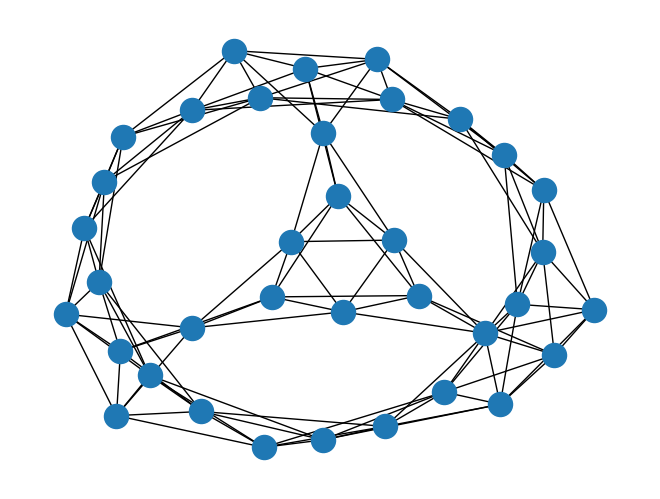

In [ ]:
# kng = KNNGraph(k=6) # Метод "KNN Graph" вернет матрицу смежности графа при условии, что присутствует поле данных
# connected_graph = kng(graph)
# print(connected_graph)
# print('edge_src:', connected_graph.edge_index[0])
# print('edge_dst:', connected_graph.edge_index[1])

nx_graph = to_networkx(connected_graph, to_undirected=True) 
# Параметр to_undirected=True объединяет направленные ребра в неориентированные
nx.draw(nx_graph)
plt.show()

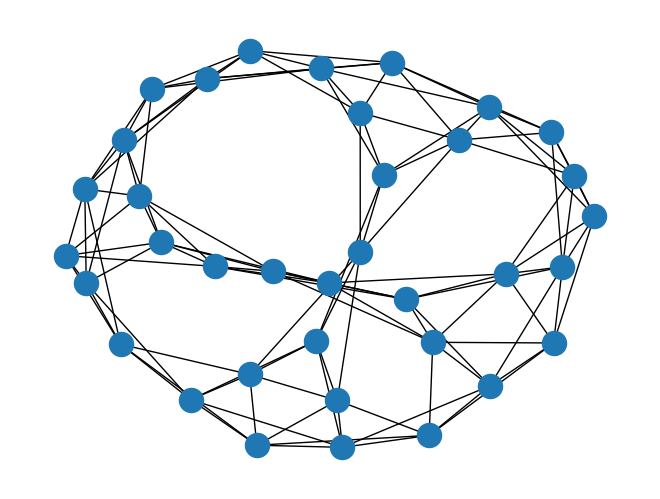

In [143]:
nx_graph_full = to_networkx(connected_graph_full, to_undirected=True) 
# Параметр to_undirected=True объединяет направленные ребра в неориентированные
nx.draw(nx_graph_full)
plt.show()

In [ ]:
# пока данный код не рабочий, но его нужно будет протестировать на других графах
# # print(nx.info(nx_graph))
# # Все узлы
# print("Узлы:", nx_graph.nodes())  # или list(nx_graph.nodes)

# # Узлы с атрибутами (если есть)
# print("Узлы с атрибутами:", nx_graph.nodes(data=True))

# # Все рёбра
# print("Рёбра:", nx_graph.edges())  # или list(nx_graph.edges)

# # Рёбра с атрибутами (если есть)
# print("Рёбра с атрибутами:", nx_graph.edges(data=True))

Узлы: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
Узлы с атрибутами: [(0, {}), (1, {}), (2, {}), (3, {}), (4, {}), (5, {}), (6, {}), (7, {}), (8, {}), (9, {}), (10, {}), (11, {}), (12, {}), (13, {}), (14, {}), (15, {}), (16, {}), (17, {}), (18, {}), (19, {}), (20, {}), (21, {}), (22, {}), (23, {}), (24, {}), (25, {}), (26, {}), (27, {}), (28, {}), (29, {}), (30, {}), (31, {}), (32, {}), (33, {}), (34, {}), (35, {})]
Рёбра: [(0, 22), (0, 18), (0, 35), (0, 1), (0, 2), (0, 7), (1, 20), (1, 15), (1, 35), (1, 28), (1, 2), (1, 23), (2, 31), (2, 26), (2, 28), (2, 18), (2, 29), (3, 21), (3, 30), (3, 14), (3, 8), (3, 5), (3, 4), (4, 21), (4, 16), (4, 24), (4, 7), (4, 10), (5, 12), (5, 34), (5, 17), (5, 30), (5, 8), (5, 13), (6, 32), (6, 27), (6, 25), (6, 11), (6, 9), (6, 10), (7, 22), (7, 33), (7, 16), (7, 10), (8, 29), (8, 26), (8, 14), (8, 17), (8, 31), (9, 23), (9, 15), (9, 19), (9, 27), (9, 11), (9, 2

### Функция преобразования в граф

Давайте определим функцию для преобразования структур в графы в формате данных torch_geometric: 

In [ ]:
# import torch
# from torch_geometric.data import Data
# from torch_geometric.transforms import KNNGraph
# from pymatgen.core import Structure

In [111]:
def get_graph(struct, y: float) -> Data:
    """
    Преобразует кристаллическую структуру (pymatgen.Structure) в граф (torch_geometric.data.Data)
    для использования в CGNN (я так понял, что для обучения, т.к. есть целевое свойство). 
    Граф включает:
    - Узлы: атомы с признаками (атомный номер, молярный объем и др.)
    - Ребра: связи между атомами (k-NN, k=6)
    - Глобальные свойства: энергия (y) и параметры решетки.

    Параметры:
    ----------
    struct : pymatgen.Structure
        Кристаллическая структура из pymatgen.
    y : float
        Целевое свойство (например, энергия образования).

    Возвращает:
    -----------
    torch_geometric.data.Data
        Граф с полями:
        - x (Tensor): Признаки узлов [num_atoms, num_features].
        - pos (Tensor): Координаты атомов [num_atoms, 3].
        - lattice (Tensor): Параметры решетки [1, 9].
        - y (Tensor): Целевое свойство [1, 1].
        - edge_index (Tensor): Индексы связей [2, num_edges].

    Пример использования:
    ---------------------
    >>> sample_struct = df.iloc[0]['structure']
    >>> sample_energy = df.iloc[0]['formation_energy_per_atom']
    >>> graph = get_graph(sample_struct, sample_energy)
    """
    # Создаем суперячейку 2x2x2 для корректного учета периодических границ
    supercell = struct.copy()
    # Повторяем ячейку 2×2×2 раза по осям a, b, c
    supercell.make_supercell([2, 2, 2])  # Теперь минимум 8 атомов (если в ячейке был 1 атом)

    # Признаки узлов (атомов):
    # -------------------------
    # Каждый атом описывается вектором [Z, molar_volume, electron_affinity, min_oxidation_state, max_oxidation_state]
    x = []
    for site in supercell:
        elem = site.species.elements[0]  # Берем первый элемент (на случай неупорядоченных структур)
        x.append([
            elem.Z,                      # Атомный номер
            elem.molar_volume,           # Молярный объем (из pymatgen)
            elem.electron_affinity,      # Сродство к электрону (эВ)
            elem.min_oxidation_state,    # Минимальная степень окисления
            elem.max_oxidation_state,    # Максимальная степень окисления
        ])
    # преобразование данных в тензоры PyTorch
    x = torch.tensor(x, dtype=torch.float32)  # [num_atoms, 5]

    # Декартовы координаты атомов (используются для построения графа)
    pos = torch.tensor(supercell.cart_coords, dtype=torch.float32)  # [num_atoms, 3]

    # Параметры решетки (хранятся как flatten-вектор 3x3=9 компонент)
    lattice = torch.tensor(supercell.lattice.matrix, dtype=torch.float32).flatten().unsqueeze(0)  # [1, 9]

    # Целевое свойство (например, энергия образования)
    y = torch.tensor([[y]], dtype=torch.float32) # [1, 1]

    # Собираем граф (пока без ребер)
    torch_graph = Data(
        x=x,            # Признаки узлов
        pos=pos,        # Координаты для k-NN
        lattice=lattice, # Параметры решетки
        y=y,            # Целевое значение
    )

    # Добавляем ребра методом k-NN (k=6)
    kng = KNNGraph(k=6)  # Каждый атом связывается с 6 ближайшими соседями
    return kng(torch_graph)  # Граф с полем edge_index [2, num_edges]

In [112]:
# Пример использования:
# ---------------------
# Предположим, df — DataFrame с колонками 'structure' (pymatgen.Structure) и 'formation_energy_per_atom'
sample_idx = 10
sample_struct = df_si_cubic_1000.loc[sample_idx, 'structure']
sample_energy = df_si_cubic_1000.loc[sample_idx, 'formation_energy_per_atom']

# Получаем граф
graph = get_graph(sample_struct, sample_energy)

# Выводим информацию:
print(
    f"Energy: {graph.y.item():.3f} eV/atom\n"
    f"Lattice: {graph.lattice.squeeze().numpy().round(4)}\n"
    f"Graph: {graph}\n"
    f"Valid: {graph.validate()}"
)

Energy: -3.044 eV/atom
Lattice: [17.5867  0.      0.      0.     17.5867  0.      0.      0.     17.5867]
Graph: Data(x=[288, 5], y=[1, 1], pos=[288, 3], lattice=[1, 9], edge_index=[2, 1728])
Valid: True


**Здесь:**
- "x" - это матрица, описывающая узлы графа размерности [num_nodes, num_node_features]
- "y" - прогнозируемое значение
- "pos" - абсолютное положение узлов в декартовом пространстве.
- "edge_index" - это матрица смежности графа в двухстрочном представлении
- "lattice" - это решетка, в которой расположены атомы (граница периодической ячейки). Вектора трансляций.

Таким образом, мы вложили в объект "Данные" всю информацию об исследуемой кристаллической структуре.

### Создадим датасет

При работе с большими объемами данных мы должны учитывать, что весь набор данных может не поместиться в объем оперативной памяти. В этом примере мы рассмотрим метод работы с большими данными:
1. Мы разместим каждый отдельный граф в отдельном объекте в файловой системе (рациональнее было бы разместить весь пакет целиком, но метод сохранения пакетов напрямую следует из описания ниже)
2. Для доступа к файлам мы создадим отдельный класс, который наследует свойства и методы класса `torch.geometric.data.Dataset`. Однако созданный класс будет иметь доступ не к оперативной, а к постоянной памяти, что снимает ограничения на объем набора данных. 

In [144]:
df_si_cubic_1000.tail(2)

,composition,formula_pretty,symmetry,material_id,structure,formation_energy_per_atom
560,"(Mg, Si, Bi)",Mg64Si32Bi,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1194936,"[[4.78909723 4.78909723 7.96644927] Mg, [4.789...",-0.049193
561,"(Na, Si)",NaSi34,crystal_system=<CrystalSystem.cubic: 'Cubic'> ...,mp-1220929,"[[11.040783 11.040783 11.040783] Na, [0. 0. 0....",0.113020


In [145]:
# формируем папку для зафиси графов
PATH_FOLDER_FOR_FILES = r"C:\Users\lazarevnv\Desktop\github_repository\GNN_for_materials_1\data\graphs_structures_562_Si_cubic"

if not os.path.exists(PATH_FOLDER_FOR_FILES):
    os.mkdir(PATH_FOLDER_FOR_FILES)

In [146]:
# Для каждой структуры в df формируем граф и записываем в виде отдельных файлов в папку
# PATH_FOLDER_FOR_FILES = r"C:\Users\lazarevnv\Desktop\github_repository\GNN_for_materials_1\data\graphs_structures_562_Si_cubic"

for idx, row in tqdm(df_si_cubic_1000.iterrows(), total=df_si_cubic_1000.shape[0]): # Цикл для датафрейма построчный
    struct = row['structure']
    graph_data = get_graph(struct, row['formation_energy_per_atom'])
    # torch.save(graph_data, os.path.join('processed', f'data_{idx}.pt'))
    torch.save(graph_data, os.path.join(PATH_FOLDER_FOR_FILES, f'data_{idx}.pt'))

100%|██████████| 562/562 [00:22<00:00, 24.53it/s]


Далее нам нужно прочитать сохраненные файлы и передать их в класс `torch_geometric.data.Dataset`. 

In [ ]:
class ProcessedDataset_new_dir(Dataset): # (наследник torch_geometric.data.Dataset)
    '''пользовательский класс ProcessedDataset для работы с предобработанными графами кристаллических структур, 
    сохраненными в файлах .pt, и выводит статистику о данных.'''

    # Инициализирует датасет:
    # root: Путь к папке с данными, transform/pre_transform/pre_filter: Опциональные функции для преобразования данных (не используются здесь).
    def __init__(self, root, new_dir_for_load_graphs, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.processed_new_dir = new_dir_for_load_graphs

    @property
    def processed_dir(self):
        return os.path.join(self.root, self.processed_new_dir)  # Кастомный путь
    
    # Возвращает список файлов .pt в папке processed
    @property
    def processed_file_names(self):
        file_names = []
        for i in os.listdir(self.processed_dir):
            if '.pt' in i:
                file_names.append(i)
        return file_names
    

    # Возвращает количество графов в датасете:
    def len(self):
        return len(self.processed_file_names)

    # Загружает граф по индексу idx
    def get(self, idx):
        # data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        # print('self.processed_new_dir', self.processed_new_dir)
        # print('f data_{idx}.pt', f'data_{idx}.pt')
        # print('os.path.join', os.path.join(self.processed_new_dir, f'data_{idx}.pt'))
        GRAPH_PATH = os.path.join(self.processed_new_dir, f'data_{idx}.pt')
        # print('GRAPH_PATH_1', GRAPH_PATH)
        GRAPH_PATH = GRAPH_PATH.replace('\\', '/')
        # print('GRAPH_PATH_2', GRAPH_PATH)
        data = torch.load(GRAPH_PATH)
        # data = torch.load(os.path.join(self.processed_new_dir, f'data_{idx}.pt').replace('\\', '/'))
        # data = torch.load(os.path.join(self.processed_new_dir, f'data_{idx}.pt'))
        return data

In [149]:
# dataset = ProcessedDataset_new_dir('./', 'processed_Fm_3m')
dataset_562_si_cubic = ProcessedDataset_new_dir('./', PATH_FOLDER_FOR_FILES)

In [150]:
dataset_562_si_cubic.processed_new_dir

'C:\\Users\\lazarevnv\\Desktop\\github_repository\\GNN_for_materials_1\\data\\graphs_structures_562_Si_cubic'

In [ ]:
# посмотрели наш пример
dataset_562_si_cubic[10]

Data(x=[288, 5], y=[1, 1], pos=[288, 3], lattice=[1, 9], edge_index=[2, 1728])

### Разбивка на Train и Test

`PyTorch Geometric" предоставляет несколько полезных утилит для работы с наборами графовых данных, *например* мы можем перетасовать набор данных и использовать первые 1032 графа в качестве обучающих, а остальные - для тестирования:

In [152]:
# 85% of data will be presented in the training set
# 85% данных образуют обучающий датасет
train_fraction = 0.85

train_set_size = round(df_si_cubic_1000.shape[0] * train_fraction)
print('Number of samples in the training set:', train_set_size)


# Define train indices to compare differen models
train_idxs = df_si_cubic_1000.sample(train_set_size).index
# Inverse selection of samples that are not in the train indices
test_idxs = df_si_cubic_1000.loc[df_si_cubic_1000.index.difference(train_idxs)].index

Number of samples in the training set: 478


In [153]:
train_idxs

Index([173, 471, 342, 103,  68,  26,   4, 276, 121, 100,
       ...
       410, 376, 504, 223, 456, 537,  52, 318, 261, 526],
      dtype='int64', length=478)

In [155]:
test_idxs, len(test_idxs)

(Index([ 14,  17,  19,  21,  47,  61,  64,  66, 107, 109, 111, 120, 127, 129,
        130, 134, 142, 144, 148, 175, 181, 185, 187, 196, 202, 211, 213, 214,
        226, 231, 241, 248, 253, 254, 269, 275, 291, 297, 306, 308, 315, 319,
        331, 335, 341, 362, 377, 383, 386, 390, 393, 394, 397, 398, 407, 411,
        414, 417, 423, 424, 425, 426, 433, 434, 435, 438, 439, 440, 459, 464,
        467, 479, 489, 498, 508, 512, 518, 527, 535, 545, 547, 548, 553, 557],
       dtype='int64'),
 84)

In [156]:

train_dataset_si_cubic = dataset_562_si_cubic[list(train_idxs)]
test_dataset_si_cubic = dataset_562_si_cubic[list(test_idxs)]

print(f'Number of training graphs: {len(train_dataset_si_cubic)}')
print(f'Number of test graphs: {len(test_dataset_si_cubic)}')

Number of training graphs: 478
Number of test graphs: 84


### Разбивка датасета по батчам (пакетам)

Чтобы разумно использовать доступные вычислительные ресурсы и ускорить доступ к данным, хранящимся в постоянной памяти, мы используем пакетную обработку данных перед их передачей в графическую нейронную сеть (также рекомендуется использовать графический процессор).

В области изображений или языка эта процедура обычно достигается путем изменения масштаба или заполнения каждого образца, чтобы создать набор изображений одинакового размера, а затем сгруппировать образцы в дополнительном измерении (пакеты с группировкой по ширине и высоте). Длина этого измерения равна количеству выборок, сгруппированных в пакет, и обычно называется `batch_size`.

Однако для графовых нейронных сетей (особенно для графов кристаллической структуры) оба описанных выше подхода либо неосуществимы, либо могут привести к чрезмерному потреблению памяти.

Таким образом, "PyTorch Geometric" предлагает другой подход для распараллеливания нескольких выборок: матрицы смежности располагаются по диагонали (создавая гигантский граф, содержащий несколько изолированных подграфов), а узлы и целевые объекты просто объединяются в узловом измерении: 

 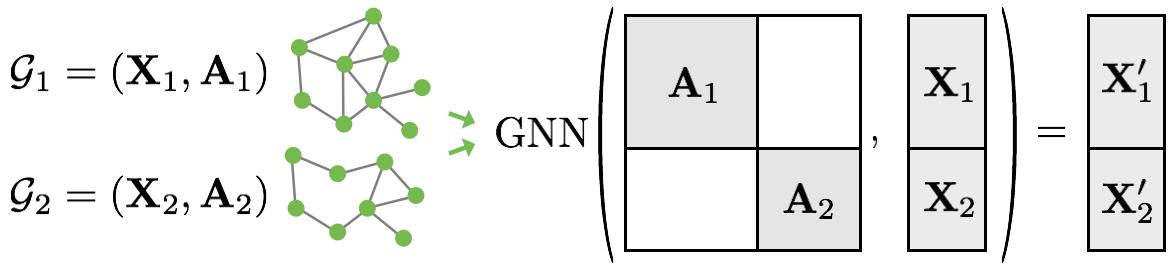 

Эта процедура имеет несколько важных преимуществ перед другими процедурами пакетной обработки:

1. Операторы GNN, которые используют схему передачи сообщений, не нуждаются в модификации, поскольку обмен сообщениями между двумя узлами, принадлежащими к разным графам, не осуществляется.

2. Нет никаких вычислительных или операционных затрат, поскольку матрицы смежности хранятся в плотной форме, содержащей только ненулевые элементы, т.е. ребра.

PyTorch Geometric автоматически распределяет выборки при группировании нескольких графов в один "гигантский" граф с использованием класса [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader`): 

In [157]:
from torch_geometric.loader import DataLoader

In [158]:
train_loader = DataLoader(train_dataset_si_cubic, batch_size=256, shuffle=True)

In [159]:
test_loader = DataLoader(test_dataset_si_cubic, batch_size=228, shuffle=False)

In [160]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 256
DataBatch(x=[41976, 5], y=[256, 1], pos=[41976, 3], lattice=[256, 9], edge_index=[2, 251856], batch=[41976], ptr=[257])

Step 2:
Number of graphs in the current batch: 222
DataBatch(x=[45856, 5], y=[222, 1], pos=[45856, 3], lattice=[222, 9], edge_index=[2, 275136], batch=[45856], ptr=[223])



In [170]:
graph.x

tensor([[14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 

In [169]:
connected_graph.x

tensor([[14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [14.0000, 12.0600,  1.3895, -4.0000,  4.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 8.0000, 17.3600,  1.4611, -2.0000,  2.0000],
        [ 

In [171]:
len(data.x)

45856

In [164]:
(data.ptr)

tensor([    0,    32,   128,   152,   184,   360,   400,   632,  1224,  1248,
         1424,  1728,  2032,  2064,  2160,  3312,  3696,  4000,  4016,  4200,
         4232,  4328,  4424,  4456,  4480,  5056,  5288,  5320,  5368,  5592,
         5656,  5832,  6152,  6728,  7016,  7248,  7472,  7512,  8088,  8104,
         8136,  8176,  8208,  8240,  8752,  8816,  8880,  9056,  9632,  9864,
         9896,  9920,  9960,  9992, 10312, 10344, 10376, 10680, 10720, 10752,
        10784, 10872, 10904, 10944, 11488, 11528, 11568, 11632, 11664, 11896,
        11960, 12024, 12048, 12280, 12856, 12912, 12984, 13816, 13856, 13896,
        13928, 13968, 14128, 14200, 14272, 14312, 14344, 14376, 14952, 15184,
        15360, 15424, 16576, 16608, 16640, 16776, 17928, 17960, 18008, 18056,
        18072, 18264, 18424, 18560, 19424, 20064, 20104, 20120, 20216, 20232,
        20408, 20696, 20720, 20952, 20984, 21008, 21040, 21616, 21856, 22432,
        22464, 22696, 23272, 23504, 23512, 23752, 23784, 24024, 

### Инициируем модель

In [ ]:
# dataset.num_node_features

5

In [177]:
# тоже самое, но уже с комментариями

class GCN(torch.nn.Module):
    """
    Графовая нейронная сеть (GNN) для предсказания свойств материалов.
    Сочетает структурную информацию (атомы и их связи) с параметрами кристаллической решётки.
    
    Параметры:
        hyperparameters (dict): Словарь с гиперпараметрами модели, включая:
            - hidden_embeding (int): Размер скрытого векторного пространства.
    """
    def __init__(self, hyperparameters):
        super(GCN, self).__init__()
        torch.manual_seed(12345)  # Фиксируем случайное начальное состояние для воспроизводимости

        # 1. Инициализация гиперпараметров
        self.hidden_embeding = hyperparameters['hidden_embeding']

        # 2. Слои для обработки структурных данных (атомы и их связи)
        # PointTransformerConv - графовый слой, учитывающий позиции атомов
        self.structural_embedding = PointTransformerConv(
            in_channels=dataset.num_node_features,  # Количество признаков узла (например, 5)

            out_channels=self.hidden_embeding       # Размер выходного эмбеддинга
        )
        print('in_channels', dataset.num_node_features)
        
        # 3. Слой для обработки параметров решётки
        # Линейный слой преобразует 9 параметров решётки (3x3 матрица) в скрытое пространство
        self.lattice_embedding = nn.Linear(9, self.hidden_embeding)

        # 4. Скрытые полносвязные слои для комбинирования признаков
        self.hidden_layers = nn.Sequential(
            # Первый слой: объединяет структурные и решёточные признаки
            Linear(self.hidden_embeding * 2, self.hidden_embeding * 3),
            nn.ReLU(inplace=True),  # Функция активации
            # Второй слой: сжатие признаков
            Linear(self.hidden_embeding * 3, self.hidden_embeding * 2),
            nn.ReLU(inplace=True),
            # Третий слой: подготовка к выходному слою
            Linear(self.hidden_embeding * 2, self.hidden_embeding),
            nn.ReLU(inplace=True)
        )

        # 5. Выходной слой (регрессия)
        self.out = Linear(self.hidden_embeding, 1)  # Предсказывает 1 значение (например, энергию)

    def forward(self, data):
        """
        Проход данных через модель.
        
        Параметры:
            data (torch_geometric.data.Data): Граф с полями:
                - x: Признаки узлов [num_nodes, num_features]
                - pos: Координаты атомов [num_nodes, 3]
                - edge_index: Индексы связей [2, num_edges]
                - lattice: Параметры решётки [batch_size, 9]
                - batch: Вектор батча [num_nodes]
                
        Возвращает:
            torch.Tensor: Предсказанное значение [batch_size, 1]
        """
        # 1. Структурный эмбеддинг (атомы + связи)
        # PointTransformerConv учитывает позиции атомов (data.pos) и связи (data.edge_index)
        x = self.structural_embedding(data.x, data.pos, data.edge_index)  # [num_nodes, hidden_embeding]

        # 2. Усреднение по графу (pooling)
        # Преобразует эмбеддинги узлов в один вектор на граф
        x = global_mean_pool(x, data.batch)  # [batch_size, hidden_embeding]

        # 3. Эмбеддинг решётки
        l = self.lattice_embedding(data.lattice)  # [batch_size, hidden_embeding]

        # 4. Объединение структурных и решёточных признаков
        x = torch.hstack([x, l])  # [batch_size, hidden_embeding * 2]

        # 5. Обработка через скрытые слои
        x = self.hidden_layers(x)  # [batch_size, hidden_embeding]

        # 6. Выходной слой
        x = self.out(x)  # [batch_size, 1]

        return x

In [173]:
# задачим гипер параметры
hyperparameters = \
    {
    'hidden_embeding':128,
    }

In [181]:
# инициируем модель
model_GCN = GCN(hyperparameters=hyperparameters)

in_channels 5


In [182]:
print(model_GCN)

GCN(
  (structural_embedding): PointTransformerConv(5, 128)
  (lattice_embedding): Linear(in_features=9, out_features=128, bias=True)
  (hidden_layers): Sequential(
    (0): Linear(in_features=256, out_features=384, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=384, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
# берем самый первый батч - пакет данных в одном графе. В данном случае тестовый батч единственный) 
first_batch = [i for i in test_loader][0]

In [ ]:
# смотрим, что он из себя представляет
first_batch

DataBatch(x=[19488, 5], y=[84, 1], pos=[19488, 3], lattice=[84, 9], edge_index=[2, 116928], batch=[19488], ptr=[85])

In [186]:
# отправим батч в модель, получим результат
model_GCN(first_batch)

tensor([[-0.2410],
        [-0.3079],
        [-0.1783],
        [-0.3045],
        [-0.2534],
        [-0.2648],
        [-0.2572],
        [-0.2656],
        [-0.0886],
        [-0.3012],
        [-0.0916],
        [-0.2228],
        [-0.2093],
        [-0.1641],
        [-0.3266],
        [-0.3281],
        [-0.3025],
        [-0.0277],
        [-0.1246],
        [-0.0951],
        [-0.0970],
        [-0.2422],
        [ 0.0032],
        [-0.0167],
        [-0.0535],
        [-0.0603],
        [-0.0667],
        [-0.0854],
        [-0.2694],
        [-0.2651],
        [-0.1112],
        [-0.2414],
        [-0.2254],
        [-0.2667],
        [-0.0536],
        [-0.0342],
        [-0.0416],
        [-0.2380],
        [-0.0139],
        [-0.0377],
        [ 0.0107],
        [-0.0388],
        [ 0.0074],
        [-0.0442],
        [-0.0403],
        [-0.0590],
        [-0.0209],
        [-0.0734],
        [-0.0258],
        [-0.0159],
        [-0.0464],
        [-0.0133],
        [-0.

In [187]:
# смотрим габариты тензора с результатом
model_GCN(first_batch).shape

torch.Size([84, 1])

Мы подготовили данные. Подготовили саму структуру нейронной сети в виде отдельного класса и инициировали модель как экземпляр этого класса сообщив ему нужные гиперпараметры.
В качестве проверки работоспособности сообщили модели один тестовый пакет данных. Модель выдала результат в виде тензора. Соответственно, модель работает. Обучать модель будем в следующем шаге. 

## Работаем